Splice junctions are points on a DNA sequence at which `superfluous' DNA is removed during the process of protein creation in higher organisms. The problem posed in this dataset is to recognize, given a sequence of DNA, the boundaries between exons (the parts of the DNA sequence retained after splicing) and introns (the parts of the DNA sequence that are spliced out). This problem consists of two subtasks: recognizing exon/intron boundaries (referred to as EI sites), and recognizing intron/exon boundaries (IE sites). (In the biological community, IE borders are referred to a ``acceptors'' while EI borders are referred to as ``donors''.)

Attribute Information:

* 1. One of {n ei ie}, indicating the class.
* 2. The instance name.
* 3-62. The remaining 60 fields are the sequence, starting at position -30 and ending at position +30. Each of these fields is almost always filled by one of {a, g, t, c}. Other characters indicate ambiguity among the standard characters according to the following table:


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import time

In [2]:
# size of our kmer words
k_mer = 5
# dimesnion space of our embedding layer
EMB_DIM = 50

#### reading and exploring the data

In [3]:
splice_data = pd.read_csv('splice.data', header=None, names = ['class', 'donor', 'sequence'])
splice_data.head()

,class,donor,sequence
0,EI,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGG...
1,EI,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGG...
2,EI,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGG...
3,EI,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGT...
4,EI,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTG...


In [4]:
# we have 3 classes in this dataset
CLASS_NUM = 3

In [5]:
len(splice_data)

3190

In [6]:
splice_data['sequence'] = splice_data.apply(lambda x: str(x['sequence']), axis=1)
splice_data.head()

,class,donor,sequence
0,EI,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGG...
1,EI,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGG...
2,EI,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGG...
3,EI,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGT...
4,EI,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTG...


In [7]:
splice_data['class'].value_counts()

N     1655
IE     768
EI     767
Name: class, dtype: int64

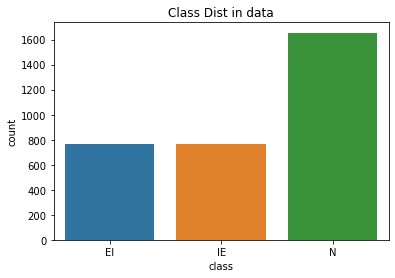

In [8]:
sns.countplot(x =splice_data['class'])
plt.title("Class Dist in data")
plt.show()

In [9]:
def kmer_fun(seq, win_size):
    kmer_list = []
    for x in range(len(seq) - win_size + 1):
        kmer_list.append(seq[x:x+win_size].lower())
    return kmer_list

#So let’s try it out with a simple sequence:
mySeq = 'CCAGCTG'
kmer_fun(mySeq, win_size= k_mer)

['ccagc', 'cagct', 'agctg']

In [10]:
splice_data['sequence'] = splice_data.apply(lambda x : x['sequence'].strip(), axis = 1)
splice_data.head()

,class,donor,sequence
0,EI,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCC...
1,EI,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGGTGAGCCCCACCGCCC...
2,EI,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGGTGAGAAGCGCAGTCG...
3,EI,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGTATGGGGCGGGGCTT...
4,EI,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTGAGTGTCCCCATCC...


In [11]:
splice_data[str(k_mer)+'-mer'] = splice_data.apply(lambda x : kmer_fun(x['sequence']
                                                    , win_size= k_mer), axis = 1)
splice_data.head()

,class,donor,sequence,5-mer
0,EI,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCC...,"[ccagc, cagct, agctg, gctgc, ctgca, tgcat, gca..."
1,EI,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGGTGAGCCCCACCGCCC...,"[agacc, gaccc, acccg, cccgc, ccgcc, cgccg, gcc..."
2,EI,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGGTGAGAAGCGCAGTCG...,"[gaggt, aggtg, ggtga, gtgaa, tgaag, gaagg, aag..."
3,EI,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGTATGGGGCGGGGCTT...,"[gggct, ggctg, gctgc, ctgcg, tgcgt, gcgtt, cgt..."
4,EI,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTGAGTGTCCCCATCC...,"[gctca, ctcag, tcagc, cagcc, agccc, gcccc, ccc..."


In [12]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
splice_data['class'] = le.fit_transform(splice_data['class'])
splice_data.head()

,class,donor,sequence,5-mer
0,0,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCC...,"[ccagc, cagct, agctg, gctgc, ctgca, tgcat, gca..."
1,0,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGGTGAGCCCCACCGCCC...,"[agacc, gaccc, acccg, cccgc, ccgcc, cgccg, gcc..."
2,0,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGGTGAGAAGCGCAGTCG...,"[gaggt, aggtg, ggtga, gtgaa, tgaag, gaagg, aag..."
3,0,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGTATGGGGCGGGGCTT...,"[gggct, ggctg, gctgc, ctgcg, tgcgt, gcgtt, cgt..."
4,0,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTGAGTGTCCCCATCC...,"[gctca, ctcag, tcagc, cagcc, agccc, gcccc, ccc..."


In [13]:
# making sentences based on the k-mers
dna_texts = list(splice_data[str(k_mer)+'-mer'])
for item in range(len(dna_texts)):
    dna_texts[item] = ' '.join(dna_texts[item])

print('Sample 1: ', dna_texts[0])

Sample 1:  ccagc cagct agctg gctgc ctgca tgcat gcatc catca atcac tcaca cacag acagg cagga aggag ggagg gaggc aggcc ggcca gccag ccagc cagcg agcga gcgag cgagc gagca agcag gcagg caggt aggtc ggtct gtctg tctgt ctgtt tgttc gttcc ttcca tccaa ccaag caagg aaggg agggc gggcc ggcct gcctt ccttc cttcg ttcga tcgag cgagc gagcc agcca gccag ccagt cagtc agtct gtctg


In [14]:
# get the labels
y = splice_data['class'].values 

In [15]:
# seperating the texts to train and test
X_train, X_test, y_train, y_test = train_test_split(dna_texts,
                                                    y,
                                                   random_state=42,
                                                   test_size=0.3,
                                                   stratify=y)


In [16]:
len(X_train), len(X_test)

(2233, 957)

In [17]:
# converting the labels to categorical one hot encoded format
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [18]:
y_train.shape, y_test.shape

((2233, 3), (957, 3))

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
VOCAB_SIZE = len(word_index)

Found 1075 unique tokens.


In [20]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
print('Sample 1 sequence: ', X_train_seq[0])
print()
X_train_padded = pad_sequences(X_train_seq, maxlen=len(X_train[0]))
print('Shape of train data tensor:', X_train_padded.shape)

Sample 1 sequence:  [361, 603, 460, 650, 288, 90, 131, 362, 845, 614, 888, 731, 191, 425, 317, 341, 245, 454, 188, 151, 376, 333, 217, 432, 143, 68, 55, 387, 492, 534, 535, 283, 81, 237, 277, 290, 223, 368, 145, 197, 100, 214, 191, 426, 388, 722, 876, 593, 562, 82, 363, 665, 751, 745, 496, 368]

Shape of train data tensor: (2233, 335)


In [21]:
X_test_seq = tokenizer.texts_to_sequences(X_test)
print('Sample 1 sequence: ',X_test_seq[0])
print()
X_test_padded = pad_sequences(X_test_seq, maxlen= len(X_train[0]))
print('Shape of test data tensor:', X_test_padded.shape)

Sample 1 sequence:  [331, 143, 14, 227, 106, 69, 81, 278, 205, 111, 93, 60, 28, 78, 129, 215, 118, 186, 5, 75, 56, 172, 306, 144, 251, 304, 37, 233, 665, 198, 184, 509, 127, 9, 12, 82, 121, 43, 38, 306, 144, 251, 304, 37, 119, 233, 115, 449, 439, 519, 708, 367, 394, 521, 225, 321]

Shape of test data tensor: (957, 335)


### Helper funtions

In [22]:
# the funciton will draw a heat map
def eval_NN_model(model, X_test, y_test, title= 'Heat map'):
    predictions = model.predict(X_test)
    preds_int = np.argmax(predictions, axis = 1)
    y_test_int = np.argmax(y_test, axis = 1)
    cm = confusion_matrix(y_test_int, preds_int)
    plot_confusion_matrix(cm, figsize=(4,4), hide_ticks=True ,cmap=plt.cm.Blues)
    plt.title(title)
    plt.xticks(range(CLASS_NUM), [str(i) for i in range(CLASS_NUM)], fontsize=12)
    plt.yticks(range(CLASS_NUM), [str(i) for i in range(CLASS_NUM)], fontsize=12)
    plt.show()
    
    f1_test = f1_score(y_test_int, preds_int, average = 'macro')
    print('test F1 score: {:.3f}'.format(f1_test))

### Models

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Conv1D
from tensorflow.keras.layers import MaxPool1D, Flatten, Dropout

In [24]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                      patience= 5, restore_best_weights= True)


#### ANN

In [25]:
chkpt1 = tf.keras.callbacks.ModelCheckpoint(
    'weights/ANN_weights', monitor='val_accuracy', verbose=0, save_best_only=True,
    save_weights_only=True
)

In [26]:
model_ANN = Sequential()
model_ANN.add(Embedding(VOCAB_SIZE+1, EMB_DIM, input_length = X_train_padded.shape[1]))
model_ANN.add(Flatten())
model_ANN.add(Dense(12, activation='relu'))
model_ANN.add(Dense(8, activation='relu'))
model_ANN.add(Dense(3, activation='softmax'))

model_ANN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ANN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 335, 50)           53800     
_________________________________________________________________
flatten (Flatten)            (None, 16750)             0         
_________________________________________________________________
dense (Dense)                (None, 12)                201012    
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 27        
Total params: 254,943
Trainable params: 254,943
Non-trainable params: 0
_________________________________________________________________


In [27]:
import time
import numpy as np

eps = 100
start = time.time()
history1 = model_ANN.fit(X_train_padded, y_train, validation_data = (X_test_padded, y_test),
          epochs = eps, batch_size = 32, shuffle = True, callbacks = [es, chkpt1])

end = time.time()
print('Took {:.3f} seconds to train'.format(end-start))

Epoch 1/100


C:\Users\moein\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


70/70 [==============================] - 2s 22ms/step - loss: 1.0142 - accuracy: 0.5141 - val_loss: 0.9553 - val_accuracy: 0.5193
Epoch 2/100
70/70 [==============================] - 2s 23ms/step - loss: 0.7718 - accuracy: 0.5396 - val_loss: 0.6409 - val_accuracy: 0.5831
Epoch 3/100
70/70 [==============================] - 2s 24ms/step - loss: 0.5006 - accuracy: 0.8200 - val_loss: 0.4494 - val_accuracy: 0.9080
Epoch 4/100
70/70 [==============================] - 2s 24ms/step - loss: 0.3112 - accuracy: 0.9400 - val_loss: 0.3162 - val_accuracy: 0.9101
Epoch 5/100
70/70 [==============================] - 2s 25ms/step - loss: 0.2016 - accuracy: 0.9852 - val_loss: 0.2485 - val_accuracy: 0.9478
Epoch 6/100
70/70 [==============================] - 2s 26ms/step - loss: 0.1334 - accuracy: 0.9919 - val_loss: 0.2089 - val_accuracy: 0.9467
Epoch 7/100
70/70 [==============================] - 2s 25ms/step - loss: 0.0749 - accuracy: 0.9978 - val_loss: 0.1855 - val_accuracy: 0.9436
Epoch 8/100
70/70 

In [28]:
model_ANN.load_weights('weights/ANN_weights')

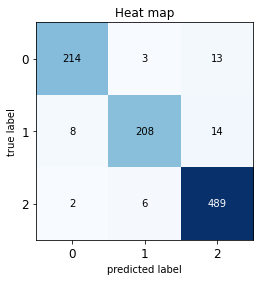

test F1 score: 0.946


In [29]:
eval_NN_model(model_ANN, X_test_padded, y_test)

#### RNN

In [30]:
chkpt2 = tf.keras.callbacks.ModelCheckpoint(
    'weights/RNN_weights', monitor='val_accuracy', verbose=0, save_best_only=True,
    save_weights_only=True
)

In [31]:
LSTM_UNITS = 50

model_RNN = Sequential()
model_RNN.add(Embedding(VOCAB_SIZE+1, EMB_DIM, input_length = X_train_padded.shape[1]))
model_RNN.add(LSTM(units = LSTM_UNITS, return_sequences = True))
model_RNN.add(LSTM(units = LSTM_UNITS))
model_RNN.add(Dense(CLASS_NUM, activation = 'softmax'))

model_RNN.compile(loss = 'categorical_crossentropy', 
                  optimizer = 'adam', metrics = ['accuracy'])
model_RNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 335, 50)           53800     
_________________________________________________________________
lstm (LSTM)                  (None, 335, 50)           20200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 153       
Total params: 94,353
Trainable params: 94,353
Non-trainable params: 0
_________________________________________________________________


In [32]:
start = time.time()
history2 = model_RNN.fit(X_train_padded, y_train, validation_data = (X_test_padded, y_test),
          epochs = eps, batch_size = 32, shuffle = True, callbacks = [es, chkpt2])
end = time.time()
print('Took {:.3f} seconds to train'.format(end-start))

Epoch 1/100


C:\Users\moein\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


70/70 [==============================] - 5s 51ms/step - loss: 0.9953 - accuracy: 0.5361 - val_loss: 0.8750 - val_accuracy: 0.5946
Epoch 2/100
70/70 [==============================] - 3s 47ms/step - loss: 0.6921 - accuracy: 0.6982 - val_loss: 0.6666 - val_accuracy: 0.6897
Epoch 3/100
70/70 [==============================] - 3s 47ms/step - loss: 0.5190 - accuracy: 0.7559 - val_loss: 0.6387 - val_accuracy: 0.7137
Epoch 4/100
70/70 [==============================] - 3s 47ms/step - loss: 0.4304 - accuracy: 0.8088 - val_loss: 0.5785 - val_accuracy: 0.7680
Epoch 5/100
70/70 [==============================] - 3s 46ms/step - loss: 0.3072 - accuracy: 0.8867 - val_loss: 0.5872 - val_accuracy: 0.7618
Epoch 6/100
70/70 [==============================] - 3s 46ms/step - loss: 0.2385 - accuracy: 0.9163 - val_loss: 0.5426 - val_accuracy: 0.8161
Epoch 7/100
70/70 [==============================] - 3s 47ms/step - loss: 0.1484 - accuracy: 0.9534 - val_loss: 0.5260 - val_accuracy: 0.8370
Epoch 8/100
70/70 

In [33]:
model_RNN.load_weights('weights/RNN_weights')

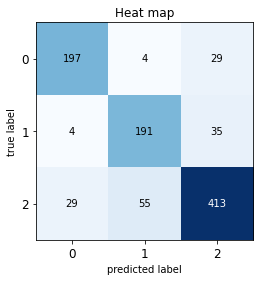

test F1 score: 0.833


In [34]:
eval_NN_model(model_RNN, X_test_padded, y_test)

#### CNN

In [35]:
chkpt3 = tf.keras.callbacks.ModelCheckpoint(
    'weights/CNN_weights', monitor='val_accuracy', verbose=0, save_best_only=True,
    save_weights_only=True
)

In [36]:
model_CNN = Sequential()
model_CNN.add(Embedding(VOCAB_SIZE+1, EMB_DIM, input_length = X_train_padded.shape[1]))
model_CNN.add(Conv1D(filters = 100, kernel_size = 3, activation='relu'))
model_CNN.add(MaxPool1D(pool_size = 2, strides=2))
model_CNN.add(Flatten())
model_CNN.add(Dropout(0.5))
model_CNN.add(Dense(CLASS_NUM, activation= 'softmax'))

model_CNN.compile(loss = 'categorical_crossentropy', 
                  optimizer = 'adam', metrics = ['accuracy'])
model_CNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 335, 50)           53800     
_________________________________________________________________
conv1d (Conv1D)              (None, 333, 100)          15100     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 166, 100)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16600)             0         
_________________________________________________________________
dropout (Dropout)            (None, 16600)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 49803     
Total params: 118,703
Trainable params: 118,703
Non-trainable params: 0
________________________________________________

In [37]:
start = time.time()
history3 = model_CNN.fit(X_train_padded, y_train, validation_data = (X_test_padded, y_test),
          epochs = eps, batch_size = 32, shuffle = True, callbacks = [es, chkpt3])
end = time.time()
print('Took {:.3f} seconds to train'.format(end-start, eps))

Epoch 1/100


C:\Users\moein\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


70/70 [==============================] - 3s 26ms/step - loss: 0.9939 - accuracy: 0.5146 - val_loss: 0.8508 - val_accuracy: 0.5789
Epoch 2/100
70/70 [==============================] - 2s 23ms/step - loss: 0.4520 - accuracy: 0.8379 - val_loss: 0.2416 - val_accuracy: 0.9310
Epoch 3/100
70/70 [==============================] - 2s 28ms/step - loss: 0.1252 - accuracy: 0.9606 - val_loss: 0.1781 - val_accuracy: 0.9415
Epoch 4/100
70/70 [==============================] - 2s 29ms/step - loss: 0.0704 - accuracy: 0.9785 - val_loss: 0.1671 - val_accuracy: 0.9415
Epoch 5/100
70/70 [==============================] - 2s 31ms/step - loss: 0.0386 - accuracy: 0.9919 - val_loss: 0.1669 - val_accuracy: 0.9425
Epoch 6/100
70/70 [==============================] - 2s 27ms/step - loss: 0.0227 - accuracy: 0.9969 - val_loss: 0.1685 - val_accuracy: 0.9425
Epoch 7/100
70/70 [==============================] - 2s 26ms/step - loss: 0.0152 - accuracy: 0.9982 - val_loss: 0.1727 - val_accuracy: 0.9436
Epoch 8/100
70/70 

In [38]:
model_CNN.load_weights('weights/CNN_weights')

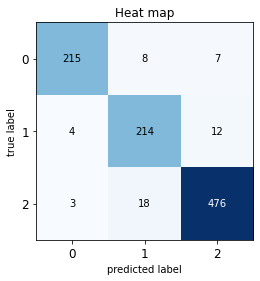

test F1 score: 0.941


In [39]:
eval_NN_model(model_CNN, X_test_padded, y_test)